<a href="https://colab.research.google.com/github/CamiloEFB/Natural_Language_Processing_with_Tensorflow_Transfer_Learning_and_Predictive_modelling_for_poetry/blob/main/Natural_Language_Processing_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing  

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. also add the basics like numpy, tensorflow, keras etc.

In [7]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Download the data 
with which we are going to work and save it in the tmp folder

In [8]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2021-06-14 21:12:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   182MB/s    in 1.3s    

2021-06-14 21:12:51 (182 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



check that it was saved **correctly**

In [9]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


# Prepare the data
first we separate the data in corpus X and labels Y. we apply [tokenizer ](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer/)that converts the words into numbers, and [padding](https://www.tensorflow.org/api_docs/python/tf/pad) so that all the words are in the same context and finally there is a separation between training set and test set and between sequences and labels

In [10]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

check that it was saved **correctly**

In [11]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138810
# 1

138810
1


# Transfer learning

The embeddings that will transfer learn from are called the GloVe, also known as Global Vectors for Word Representation, available at: https://nlp.stanford.edu/projects/glove/

In [12]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://resources.oreilly.com/conferences/natural-language-processing-with-deep-learning/raw/master/data/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2021-06-14 21:13:06--  https://resources.oreilly.com/conferences/natural-language-processing-with-deep-learning/raw/master/data/glove.6B.100d.txt
Resolving resources.oreilly.com (resources.oreilly.com)... 199.27.144.213, 199.27.144.212
Connecting to resources.oreilly.com (resources.oreilly.com)|199.27.144.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  7.05MB/s    in 42s     

2021-06-14 21:13:49 (7.85 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



check that it was saved **correctly**

In [13]:
print(len(embeddings_matrix))
# Expected Output
# 138811

138811


# Build the model
This is a sequential model that uses the transfer learning weights for greater effectiveness and with regularizations such as **batch normalization**, **alphadrop**, and filters like **Conv1d** and that we use `kernel_initializer=he_normal` and activation elu as well as **early stopping** an optimizer like nadam with a `learning_rate=4e-4` we run it in **100 epochs** but not before getting a summary of the model with `model.summary()`.

This was the model that gave me the best results



In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AlphaDropout(rate=0.2),
    tf.keras.layers.Conv1D(256, 5, kernel_initializer="he_normal",
                                 activation="elu"),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = keras.optimizers.Nadam(learning_rate=4e-4)
model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
model.summary()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_nlp3_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_nlp3_alpha_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, tensorboard_cb]

num_epochs = 100

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),callbacks=callbacks , verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13881100  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 100)           400       
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 256)           128256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 256)            394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)              

This model gave the best results with an accuracy of 84.69% and a val_accuracy of 74.27%, it is a little overfitting but it is within the parameters and with early stopping it stopped at `epoch 28/100.`

then the accuracy, val_accuracy, loss and val_loss will be graphed

<Figure size 432x288 with 0 Axes>

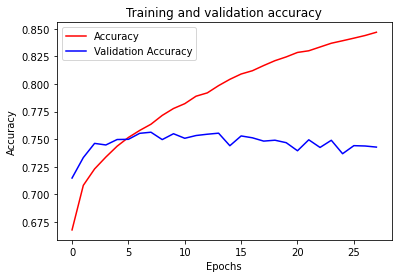

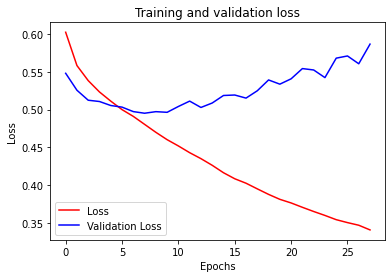

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

You can clearly see that accuracy goes up while val_accuracy stagnates this shows overfitting, and the loss and val_loss the first decreases over time the second is basically stagnant